In [1]:
%matplotlib inline
import sys
sys.path.append('../../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from collections import OrderedDict, namedtuple, defaultdict
import time
#from modules.backtesting import BackTester
from modules.db_manager import open_file, product_info

In [2]:
feed = open_file('h5py', 'etc/ohlct.h5', mode='r')

In [3]:
class Market:
    """
    시장 정보 제공
    매매신호 생성기능
    """
    
    long = Long = L = 1
    short = Short = S = -1
    commission = 3.5 #편도 수수료
    
    def __init__(self, feed, sig_gen=None):
        """
        feed: pandas dataframe 형식의 시장 기초데이터
         1) 일별 date, open, high, low, close 가격정보

        sig_gen: signal 생성 함수
        """
        if not sig_gen:
            sig_gen = self.default_sig_gen
        self.pinfo = {}
        self.preprocessing(feed, sig_gen)
        
    def preprocessing(self, feed, sig_gen):
        """
        종목별로 시그널을 생성하여 feed에 merge하고
        종목별 데이터를 날짜순으로 모두 합침
        """
        header = feed.attrs['columns'].split(';') #데이터 명
        
        container = []
        pinfo = product_info()
        for (cnt,inst) in enumerate(feed.values()):
            if cnt == 10:
                break
            
            symbol =  inst.attrs['symbol']
            if symbol == 'None' or not symbol:
                continue
            else:
                self.pinfo[symbol] = pinfo[symbol]
            
            datatable = pd.DataFrame(inst.value[:,1:], index=inst.value[:,0].astype('M8[s]'), columns=header[1:])
            datatable.sort_index(inplace=True)
            
            if sig_gen:
                print(f"\r preprocessing data...({cnt})          ", end='', flush=True)
                sig_gen(datatable)
            columns = datatable.columns.tolist()
            new_column = [[symbol for i in range(len(columns))], columns]
            datatable.columns = new_column
            container.append(datatable)
        print('\nDone')
            
        self.feed = pd.concat(container, axis=1).sort_index(axis=1)
    
    @classmethod
    def price_to_money(cls, value, pinfo):
        return value * pinfo['tick_value'] / pinfo['tick_unit']
    
    @classmethod
    def get_profit(self, pinfo, position, entryprice, exitprice, lot=1):
        """
        틱: (청산가격 - 진입가격)/틱단위
        손익계산: 랏수 * 틱가치 * 틱      
        """
        if np.isnan(entryprice) or np.isnan(exitprice):
            raise ValueError('Nan value can not be calculated')
        
        tick = round(position * (exitprice - entryprice)/pinfo['tick_unit'])
        profit = lot * pinfo['tick_value']* tick
        
        return profit, tick
    
    @classmethod
    def get_price(cls, pinfo, price1, price2, skid):
        """
        진입 주문시 슬리피지 계산
        """
        bound = (price2 - price1)*skid
        price = np.random.uniform(price1, price1 + bound)
        price = round(price, pinfo['decimal_places'])
        
        return price
    
    
    @classmethod
    def get_lot(cls, pinfo, risk, heat):
        lot = int(heat / risk)
        return lot
    
    @classmethod
    def set_ATR(cls, metrics, span=20):
            df = pd.DataFrame()
            df['hl'] = metrics['high'] - metrics['low']
            df['hc'] = np.abs(metrics['high'] - metrics['close'].shift(1))
            df['lc'] = np.abs(metrics['low'] - metrics['close'].shift(1))
            df['TR'] = df.max(axis=1)
            metrics['ATR'] = df['TR'].ewm(span).mean()
    
    @staticmethod
    def default_sig_gen(datatable):
        """
        시장 기초데이터로부터 MA, trend index등을 생성하는 
        data preprocessing method이다.
        
        datatable: 종목별 ohlc 데이터를 저장한 pandas dataframe
        default 값으로 20일 이평과 60일 이평을 추가한다.
        
        """
        Market.set_ATR(datatable, span=20)
        
        datatable['ma20'] = datatable['close'].rolling(20).mean()
        datatable['ma60'] = datatable['close'].rolling(20).mean()
        datatable.dropna(inplace=True)

In [118]:
class Trader:
    """
    트레이더 봇
    매매전략 
    매매기록
    매매분석
    """
    def __init__(self, market, principal, portfolio_heat, heat, 
                 strategy=None, stop_rule=None, max_lot=None):
        # 시장 정보 설정
        self.feed = market.feed
        self.pinfo = market.pinfo.copy()
        
        if strategy:
            Trader.strategy = strategy
        else:
            Trader.strategy = Trader.default_strategy
    
        if stop_rule:
            self.stop_rule = stop_rule
        else:
            self.stop_rule = self.default_stop_rule

        #자산 초기값 설정
        self.capital = principal
        self.equity = principal
        self.avail_equity = principal
        self.real_equity = principal
        self.cum_commission = 0 #누적 수수료
        self.maxlot = max_lot
        
        #매매규칙 초기값 설정
        self._portfolio_heat = portfolio_heat
        self._heat = heat
        
        #매매관련 정보
        self.entryid = 0
        self._tradelog = [] #매매 기록
        self._equitylog = [] #자산 기록
        self._rejected_order = [] #진입 거부된 매매
        self.open_entries = { 
            symbol: {Market.long:{}, Market.short:{} } for symbol in self.pinfo.keys()
        }
    
    @property
    def tradelog(self):
        columns = ['id','inst','pos','entry date','entry price','entry lot',
                   'exit date','exit price','exit lot','force exit','profit','tick']
        return pd.DataFrame(self._tradelog, columns = columns)
    
    @property
    def equitylog(self):
        columns = ['date', 'capital','open profit','equity','real equity',
                   'port risk', 'cum commission']
        return pd.DataFrame(self._equitylog, columns=columns).set_index('date')
    
    @property
    def rejected_order(self):
        columns = ['num trades','name','date','real equity', 'risk','risk capa',
                   'port risk', 'port risk capa','strategy','type']
        return pd.DataFrame(self._rejected_order, columns=columns)
    
    @property
    def heat(self):
        return self._heat * self.real_equity
    
    @property
    def portfolio_heat(self):
        return self._portfolio_heat * self.real_equity
    
    @property
    def portfolio_risk(self):
        portfolio_risk = 0
        for inst in self.open_entries.values():
            for position in inst.values():
                for strat in position.values():
                    portfolio_risk += strat['risk']
                
        return portfolio_risk
    
    def get_risk(self, info, position, entryprice, stopprice, lot=1):
        """
        리스크 계산기
        리스크 = (진입가 - 스탑가격) * 가격유닛 * 랏수
        """
        pricediff = position * (entryprice - stopprice)
        risk_per_lot = Market.price_to_money(pricediff, info) if pricediff > 0 else 0
        return risk_per_lot * lot
    
    def run_trade(self):
        symbols = self.feed.columns.levels[0] #종목 코드
        for date, metrics in self.feed.iterrows():
            print("\r now trading at %s         "%date, end='', flush=True)
            self.commission = 0
            
            for symbol in symbols:
                metric = metrics[symbol]
                info = self.pinfo[symbol]
                if not metric.hasnans:
                    self.strategy(info, metric)
                
            # 강제청산 모니터링 및 매매기록
            self.force_stop(metrics)
            self.write_equitylog(metrics)
            if self.equity < 0:
                print("\nYou went bankrupt!")
                break
                
    def buy(self, info, position, date, entryprice, stopprice, strat='strat_0', ref=None):
        
        risk = self.get_risk(info, position, entryprice, stopprice, lot=1)
        port_risk = self.portfolio_risk
        heat = self.heat
        port_heat = self.portfolio_heat
        num_trades = self.count_trades()
        
        
        if risk > heat:
            self._rejected_order.append([num_trades, info['name'], date, self.real_equity, risk, heat,
                                         port_risk, port_heat, strat, 1])
        
        elif port_risk + risk > port_heat:
            self._rejected_order.append([num_trades, info['name'], date, self.real_equity, risk, heat,
                                         port_risk, port_heat, strat, 2])
        
        else:
            self.entryid += 1
            symbol = info['group']
            entrylot = Market.get_lot(info, risk, heat)
            
            #최대허용가능 랏수
            if self.maxlot and entrylot > self.maxlot:
                entrylot = self.maxlot
            
            #진입하려는 전략이 이미 매매중인 경우 에러
            if strat in self.open_entries[symbol][position]:
                raise AttributeError(f"open entry for '{symbol}' on '{position}' already exist!")
            
            #가격이 이상한 경우 에러
            if np.isnan(entryprice) or np.isnan(stopprice):
                raise ValueError(f"Price {price} can not be NaN value")
                    
            else:
                self.open_entries[symbol][position][strat] = {
                    'entryid': self.entryid,
                    'strategy': strat,
                    'instrument': info,
                    'position': position,
                    'entrydate': date,
                    'entryprice': entryprice,
                    'entrylot': entrylot,
                    'openlot': entrylot,
                    'stopprice': stopprice,
                    'risk': risk,
                    'ref': ref
                }
                self.commission += (entrylot * Market.commission)
            

    def sell(self, info, position, date, price, strat='strat_0', force=False):
        symbol = info['group']
        if strat not in self.open_entries[symbol][position]:
            return
        
        else:
            open_entry = self.open_entries[symbol][position][strat]
        
        entryid = open_entry['entryid']
        inst = info['name']
        entrydate = open_entry['entrydate']
        entryprice = open_entry['entryprice']
        entrylot = open_entry['entrylot']
        openlot = open_entry['openlot']
            
        exitdate = date
        exitprice = price
        exitlot = entrylot
            
        profit, tick =  Market.get_profit(info, position, entryprice, exitprice, lot=exitlot)
        
        openlot = openlot - exitlot
        if openlot < 0:
            raise ValueError("exit lot cannot be greater than open lot")
                
        elif openlot == 0:
            del self.open_entries[symbol][position][strat]
            
        else:
            open_entry['openlot'] = openlot
                
        pos = 'Long' if position == Market.long else 'Short'
        self._tradelog.append([entryid, inst, pos, entrydate, entryprice, entrylot,
                               exitdate, exitprice, exitlot,force, profit, tick])
        
        self.commission += (exitlot * Market.commission)
        self.capital += profit
        
    def write_equitylog(self, metrics):
        
        date = metrics.name
        open_profit, open_margin = self.update_status(metrics)
        portfolio_risk = self.portfolio_risk
        
        self.cum_commission += self.commission
        self.capital = self.capital - self.commission
        self.equity = self.capital + open_profit
        self.avail_equity = self.equity - open_margin
        self.real_equity = self.equity - portfolio_risk
        self._equitylog.append([date, self.capital, open_profit, self.equity,
                                self.real_equity, portfolio_risk,  self.cum_commission])
        
    def update_status(self, metrics):
        """
        1. stop price 업데이트
        2. 자산 업데이트
        """
        
        open_profit = 0
        open_margin = 0
        
        for inst in self.open_entries.values():
            for position, strats in inst.items():
                for strat in strats.values():
                    info = strat['instrument']
                    symbol = info['group']
                    metric = metrics[symbol]
                
                    if not metric.hasnan:
                        profit, tick = Market.get_profit(info, position, strat['entryprice'],
                                                         metric['close'], lot=strat['openlot'])
                        strat['open_profit'] = profit
                    
                    open_profit += strat['open_profit']
                    open_margin += strat['openlot'] * info['keep_margin']
                
                    if np.isnan(open_profit):
                        raise ValueError("Open profit can not be NaN value")
                    
                    #risk update
                    strat['risk'] = self.get_risk(info, position, strat['entryprice'], strat['stopprice'], lot=strat['openlot'])
                    
        return open_profit, open_margin
        
    def force_stop(self, metrics):
        date = metrics.name
        
        for inst in self.open_entries.values():
            for position, strats in inst.items():
                for stratname in list(strats):
                    strat = inst[position][stratname]
                    info = strat['instrument']
                    symbol = info['group']
                    high = metrics[symbol]['high']
                    low = metrics[symbol]['low']
                
                    if np.isnan(high) or np.isnan(low):
                        continue
                        
                    else:
                        stopprice = strat['stopprice']
                    
                        if position == Market.long:
                            pricediff = low - stopprice
                    
                        elif position == Market.short:
                            pricediff = stopprice - high

                        #강제청산
                        if pricediff < 0: 
                            self.sell(info, position, date, stopprice, strat=stratname, force=True)
                            
                        #stop 가격 업데이트
                        else:
                            strat['stopprice'] = self.stop_rule(info, position, metrics[symbol], ref=strat['ref'])
    
    def count_trades(self):
        cnt = 0
        for inst in self.open_entries.values():
            for pos in inst.values():
                for strat in pos.values():
                    cnt += 1
        return cnt
    
    def default_strategy(self, info, metric):
        """
        ** default strategy: long only MA cross system **
        진입: 20종가이평이 60종가이평 돌파상승 한 다음날 시가 진입
        청산: 진입한 투자금(증거금) 대비 10% 이상 평가손실시 청산
        """
        # 신호 확인
        if metric['signal'] == 1:
            #stop_price = Market.convert(metric['ATR'] * 5, info, origin='price', to='money')
            entryprice= Market.get_price(info, metric['open'], metric['high'], skid=0.5)
            info['refprice'] = entryprice
            position = Market.long
            stopprice = self.stop_rule(info, position, metric)
            
            self.buy(info, position, date, entryprice, stopprice, strat='TF')
        if metric['signal'] == -1:
            exitprice = Market.get_price(info, metric['open'], metric['low'], skid=0.5)
            self.sell(info, metric.date, exitprice, strat='TF')
            
    @staticmethod        
    def default_stop_rule(info, position, metric, ref=None):
        if position == Market.long:
            #stopprice = metric['close'] - diff*3
            stopprice = ref - metric['ATR']*2
        elif position == Market.short:
            #stopprice = metric['close'] + diff*3
            stopprice = ref + metric['ATR']*2
        return stopprice

In [5]:
def gen_signal(datatable):
    #추세지속일수
    days = 3
    
    Market.set_ATR(datatable, span=20)
    
    #추세 누적 지속일수
    down = up = 0
    for date, metric in datatable.iterrows():
        trend = metric['trend']
        if trend == 0:
            down += 1
            up = 0
        elif trend == 1:
            up = 0
            down = 0 
        elif trend == 2:
            up += 1
            down = 0
        
        datatable.loc[date, 'up'] = up
        datatable.loc[date, 'down'] = down    

In [6]:
market = Market(feed=feed, sig_gen=gen_signal)

 preprocessing data...(9)          
Done


In [25]:
def strat(trader, info, metric):
    symbol = info['group']
    if ('up' in info) and (info['up'] == 3):
        if 'TF' not in trader.open_entries[symbol][Market.long]:
            entryprice =  Market.get_price(info, metric['open'], metric['high'], skid=0.5)
            position = Market.long
            stopprice = trader.stop_rule(info, position, metric, ref=entryprice)
            trader.buy(info, position, metric.name, entryprice, stopprice, strat='TF', ref=entryprice)
    
    elif ('up' in info) and (info['up'] == 0):
        if 'TF' in trader.open_entries[symbol][Market.long]:
            exitprice = Market.get_price(info, metric['open'], metric['low'], skid=0.5)
            trader.sell(info, Market.long, metric.name, exitprice, strat='TF')
            
    if ('down' in info) and (info['down'] == 3):
        if 'TF' not in trader.open_entries[symbol][Market.short]:
            entryprice =  Market.get_price(info, metric['open'], metric['low'], skid=0.5)
            position = Market.short
            stopprice = trader.stop_rule(info, position, metric, ref=entryprice)
            trader.buy(info, position, metric.name, entryprice, stopprice, strat='TF', ref=entryprice)
        
        
    elif ('down' in info) and (info['down'] == 0):
        if 'TF' in trader.open_entries[symbol][Market.short]:
            exitprice = Market.get_price(info, metric['open'], metric['high'], skid=0.5)
            trader.sell(info, Market.short, metric.name, exitprice, strat='TF')
            
    if not np.isnan(metric['up']):
        info['up'] = metric['up']
    
    if not np.isnan(metric['down']):
        info['down'] = metric['down']

In [93]:
def stop_rule(info, position, metric, ref=None):
    #if metric['close'] > info['refprice'] * 1.1:
    #    info['refprice'] = metric['close'] 
    #if metric['ATR'] == 0:
    #    diff = metric['close'] * 0.1
    #else:
    #    diff = metric['ATR']
    
    if position == Market.long:
        #stopprice = metric['close'] - diff*3
        stopprice = ref - metric['ATR']*2
    elif position == Market.short:
        #stopprice = metric['close'] + diff*3
        stopprice = ref + metric['ATR']*2
    return stopprice

In [119]:
trader = Trader(market=market,
                principal=10000,
                portfolio_heat=0.3,
                heat=0.1,
                max_lot=None,
                strategy=strat,
                stop_rule=stop_rule)

In [120]:
%%time
trader.run_trade()

 now trading at 2014-12-31 00:00:00         Wall time: 19 s


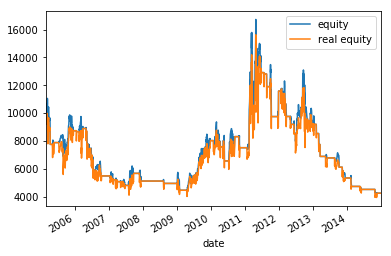

In [97]:
trader.equitylog[['equity','real equity']].plot()

In [121]:
trader.tradelog

,id,inst,pos,entry date,entry price,entry lot,exit date,exit price,exit lot,force exit,profit,tick
0,3,Corn,Long,2005-03-17,501.5700,1,2005-03-21,491.054993,1,True,-525.00,-42.0
1,2,Soybean Oil,Long,2005-03-14,52.7100,1,2005-03-23,51.190762,1,True,-912.00,-152.0
2,1,Eurodollar,Short,2005-03-07,93.7444,3,2005-04-15,93.845589,3,True,-750.00,-40.0
3,5,Eurodollar,Long,2005-05-10,93.7352,2,2005-05-11,93.743000,2,False,37.50,3.0
4,4,Corn,Short,2005-05-09,475.7300,1,2005-05-18,475.590000,1,False,12.50,1.0
5,6,Eurodollar,Long,2005-05-20,93.7701,2,2005-05-24,93.790400,2,False,100.00,8.0
6,7,Eurodollar,Short,2005-07-18,93.5815,4,2005-09-01,93.617046,4,True,-350.00,-14.0
7,8,Soybean Oil,Short,2005-08-19,50.9100,1,2005-09-06,51.200000,1,False,-174.00,-29.0
8,10,Soybean Oil,Short,2005-09-09,50.7900,1,2005-09-22,51.871661,1,True,-648.00,-108.0
9,11,Eurodollar,Short,2005-10-07,93.1166,2,2005-10-13,93.093000,2,False,112.50,9.0


In [117]:
np.isnan(np.nan)

True

In [109]:
s.hasnans

True

In [54]:
a.groupby('inst')['profit'].sum()

inst
Australian Dollar      380.00
British Pound        -4381.25
Canadian Dollar      -5300.00
Corn                  -112.50
Crude Oil (WTI)     -16230.00
Euro FX             -36950.00
Eurodollar           -3025.00
Soybean Oil            966.00
Name: profit, dtype: float64

In [213]:
b = a['ATR']

In [218]:
b.name

'ATR'